In [1]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn import pipeline

from datetime import datetime
import time

# 1. Loading the Data
    - listings.csv.gz | has all the information for a given listing

In [2]:
listingsGZ_df = pd.read_csv('Denver AirBnB/listings.csv.gz', compression='gzip',
                   error_bad_lines=False)

# 2) Data Wrangling

#### 2.1) Selecting Desired Features

In [3]:
mass_model_cols = [
       'price', 'id', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews','number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'neighbourhood'
        ]

In [4]:
set(listingsGZ_df.columns) - set(mass_model_cols) # these columns not useful (unrelated, all NANs, difficult to quantify)

{'bathrooms',
 'calendar_last_scraped',
 'calendar_updated',
 'description',
 'first_review',
 'host_about',
 'host_id',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_thumbnail_url',
 'host_url',
 'last_review',
 'last_scraped',
 'license',
 'listing_url',
 'name',
 'neighborhood_overview',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'picture_url',
 'scrape_id'}

In [5]:
master_df = listingsGZ_df[mass_model_cols]

#### 2.2) Changing price data type

In [6]:
master_df['price'] = master_df['price'].str.replace('$', '')
master_df['price'] = master_df['price'].str.replace(',', '').astype(float)
master_df['price'] = master_df['price'].astype(float)

<ipython-input-6-31814f604166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['price'] = master_df['price'].str.replace('$', '')
<ipython-input-6-31814f604166>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['price'] = master_df['price'].str.replace(',', '').astype(float)
<ipython-input-6-31814f604166>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

#### 2.3) Modify host_since

In [7]:
master_df['host_since'] = pd.to_datetime(master_df['host_since'])

day_last_scraped = datetime(2021, 9, 30).date()
master_df['host_since'] = master_df['host_since'].apply(lambda x: (day_last_scraped - x.date()).days )
master_df.rename(columns={'host_since': 'host_days'}, inplace=True)

<ipython-input-7-34d22ada07de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['host_since'] = pd.to_datetime(master_df['host_since'])
<ipython-input-7-34d22ada07de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['host_since'] = master_df['host_since'].apply(lambda x: (day_last_scraped - x.date()).days )
C:\Users\Trey\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

#### 2.3) Feature Engeneering shared_bathroom | Changing bathroom_qty to integers

In [8]:
master_df['shared_bathroom'] = master_df['bathrooms_text'].str.contains('shared', case=False)
master_df['shared_bathroom'].loc[master_df['shared_bathroom'] == True] = 1
master_df['shared_bathroom'].loc[master_df['shared_bathroom'] == False] = 0
master_df = master_df.dropna(axis=0, subset=['shared_bathroom']).reset_index(drop=True)
master_df['shared_bathroom'] = master_df['shared_bathroom'].astype(int)

master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace('Half-bath','.5')
master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace('Shared half-bath','.5')
master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace(r'[aA-zZ]+','')
master_df['bathrooms_text'] = master_df['bathrooms_text'].str.replace(' ','')
master_df['bathrooms_text'] = master_df['bathrooms_text'].astype(float)

master_df.rename(columns = {'bathrooms_text' : 'bathroom_qty'}, inplace=True)

<ipython-input-8-ae999e1c9e58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['shared_bathroom'] = master_df['bathrooms_text'].str.contains('shared', case=False)
C:\Users\Trey\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-8-ae999e1c9e58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

#### 2.4) Modfying host_response_rate, host_acceptance_rate

In [9]:
rate_cols = ['host_response_rate', 'host_acceptance_rate']

for rate_col in rate_cols:
    master_df[rate_col] = master_df[rate_col].str.replace('%','')
    master_df[rate_col] = master_df[rate_col].astype(float)
    master_df[rate_col] = master_df[rate_col].fillna(value=round(master_df[rate_cols].mean() ))

#### 2.5) Modfying: host_is_superhost, host_has_profile_pic, host_identity_verified, has_availability, instant_bookable

In [10]:
binary_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']

for binary_col in binary_cols:
    master_df[binary_col].loc[master_df[binary_col] == 't'] = 1
    master_df[binary_col].loc[master_df[binary_col] == 'f'] = 0
    master_df[binary_col] = master_df[binary_col].astype(int)

C:\Users\Trey\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### 2.6) Modfying: host_verifications, amenities

In [11]:
count_cols = ['host_verifications', 'amenities']

for count_col in count_cols:
    master_df[count_col] = master_df[count_col].apply(lambda x: len( eval(x) ) )

#### 2.7) Categorical Variables: 'property_type', 'host_response_time', 'room_type', 'neighbourhood'

In [12]:
dummy_cols = ['property_type', 'host_response_time', 'room_type', 'neighbourhood']
master_df['room_type'] = master_df['room_type'].str.replace('Private room','Private room type')

for dummy_col in dummy_cols:
    ### Target Encoding ###
    master_df[dummy_col+"_encoded"] = master_df.groupby(dummy_col)["price"].transform("median")
    master_df.drop(columns=dummy_col, inplace=True)
    
    ### One hot Encode ###
    #master_df = pd.concat([master_df, pd.get_dummies(master_df[dummy_col]) ],
    #                    axis=1).drop(columns=dummy_col)


#### 2.8) NA Values

In [13]:
master_df['bedrooms'].value_counts()/len(master_df)

1.0     0.486733
2.0     0.287721
3.0     0.108481
4.0     0.036420
5.0     0.014828
6.0     0.004422
9.0     0.000520
16.0    0.000260
7.0     0.000260
8.0     0.000260
Name: bedrooms, dtype: float64

In [14]:
master_df['bedrooms'] = master_df['bedrooms'].fillna(1)

In [15]:
na_cols = ['beds', 'review_scores_accuracy', 'bathroom_qty',
       'review_scores_cleanliness', 'review_scores_checkin', 'host_acceptance_rate',
       'review_scores_communication', 'review_scores_location', 'host_response_rate',
       'review_scores_value', 'reviews_per_month', 'review_scores_rating', 'host_response_time_encoded',
       'neighbourhood_encoded']

master_df[na_cols] = master_df[na_cols].apply(lambda x: x.fillna( x.median() ), axis=0)

# 3) EDA

#### Summary:
    Noticed dropping outliars changed the correlations between IVs and DV. 

In [16]:
"""Calculates and returns a df for dropping outlairs based of 1.5IQR and zscores"""
def outlair_removal(df, vari='price'):
    iqr_df = df.copy()
    iqr_desc = iqr_df[vari].describe()
    upper_range = iqr_desc[6]+( 1.5*(iqr_desc[6]-iqr_desc[4]) )
    lower_range = iqr_desc[4]-( 1.5*(iqr_desc[6]-iqr_desc[4]) )
    iqr_df = iqr_df.loc[(upper_range >= iqr_df[vari]) & (iqr_df[vari] >= lower_range) ]
    
    zscore_df = df.copy()
    zscore_df['var_zscore'] = zscore_df[[vari]].apply(stats.zscore).values
    zscore_df = iqr_df.loc[(3 >= zscore_df['var_zscore']) & (zscore_df['var_zscore'] >= -3) ]
    
    return iqr_df, zscore_df

In [17]:
"""Plots the distribution and percentage of occurances for each value that occures more than 1% of the time"""
def plot_distibution(column, df=master_df):
    plt.figure(figsize=(20,6))
    fig = sns.histplot(x=df[column], kde=True)
    plt.title("Distribution of: "+column, fontsize=20);
    
    value_counts = df[column].value_counts(dropna=True, sort=True)
    df_val_counts = pd.DataFrame(value_counts)
    df_value_counts_reset = df_val_counts.reset_index()
    df_value_counts_reset.columns = [column, 'Count']
    df_value_counts_reset['Count Percent'] = df_value_counts_reset['Count'] /len(df)
    return df_value_counts_reset.loc[df_value_counts_reset['Count Percent'] > 0.01]

### 3.1) Response Variable: price
#### Summary
 - Removed outliars and then removed rows that did not have a given amount on reviews (19). This removed a lot of the right skew and helped get the data closer to a normal distrobution.

,price,Count,Count Percent
0,99.0,77,0.020031
1,100.0,64,0.016649
2,150.0,61,0.015869
3,125.0,59,0.015349
4,75.0,57,0.014828
5,80.0,47,0.012227
6,65.0,44,0.011446
7,135.0,43,0.011186
8,120.0,43,0.011186
9,200.0,43,0.011186


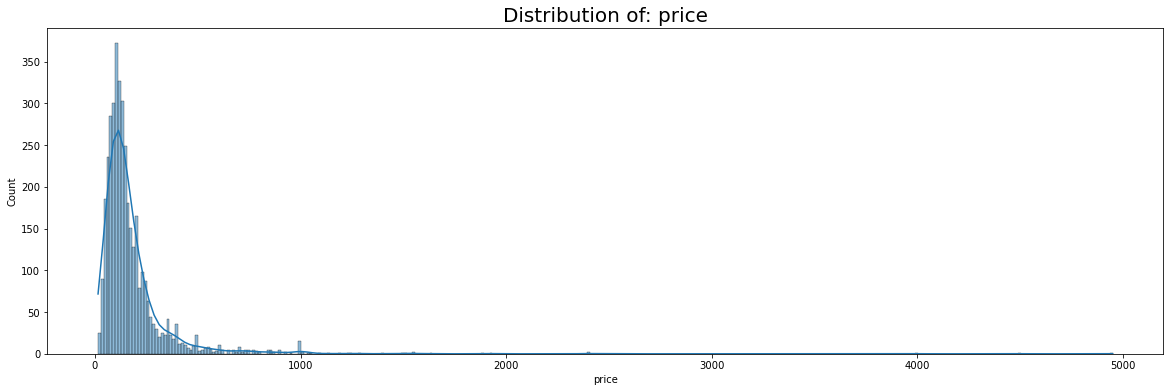

In [18]:
plot_distibution('price')

## 3.2) Investigating Highest Correlations

In [19]:
model_df = master_df.drop(columns=['id'])

In [20]:
corr_df = model_df.corr()[['price']]

### Positive Values

In [21]:
corr_df.loc[corr_df['price'] > .1]

,price
price,1.000000
accommodates,0.456714
bathroom_qty,0.499953
bedrooms,0.480827
beds,0.497750
availability_30,0.164094
availability_60,0.121452
property_type_encoded,0.318524
room_type_encoded,0.160747


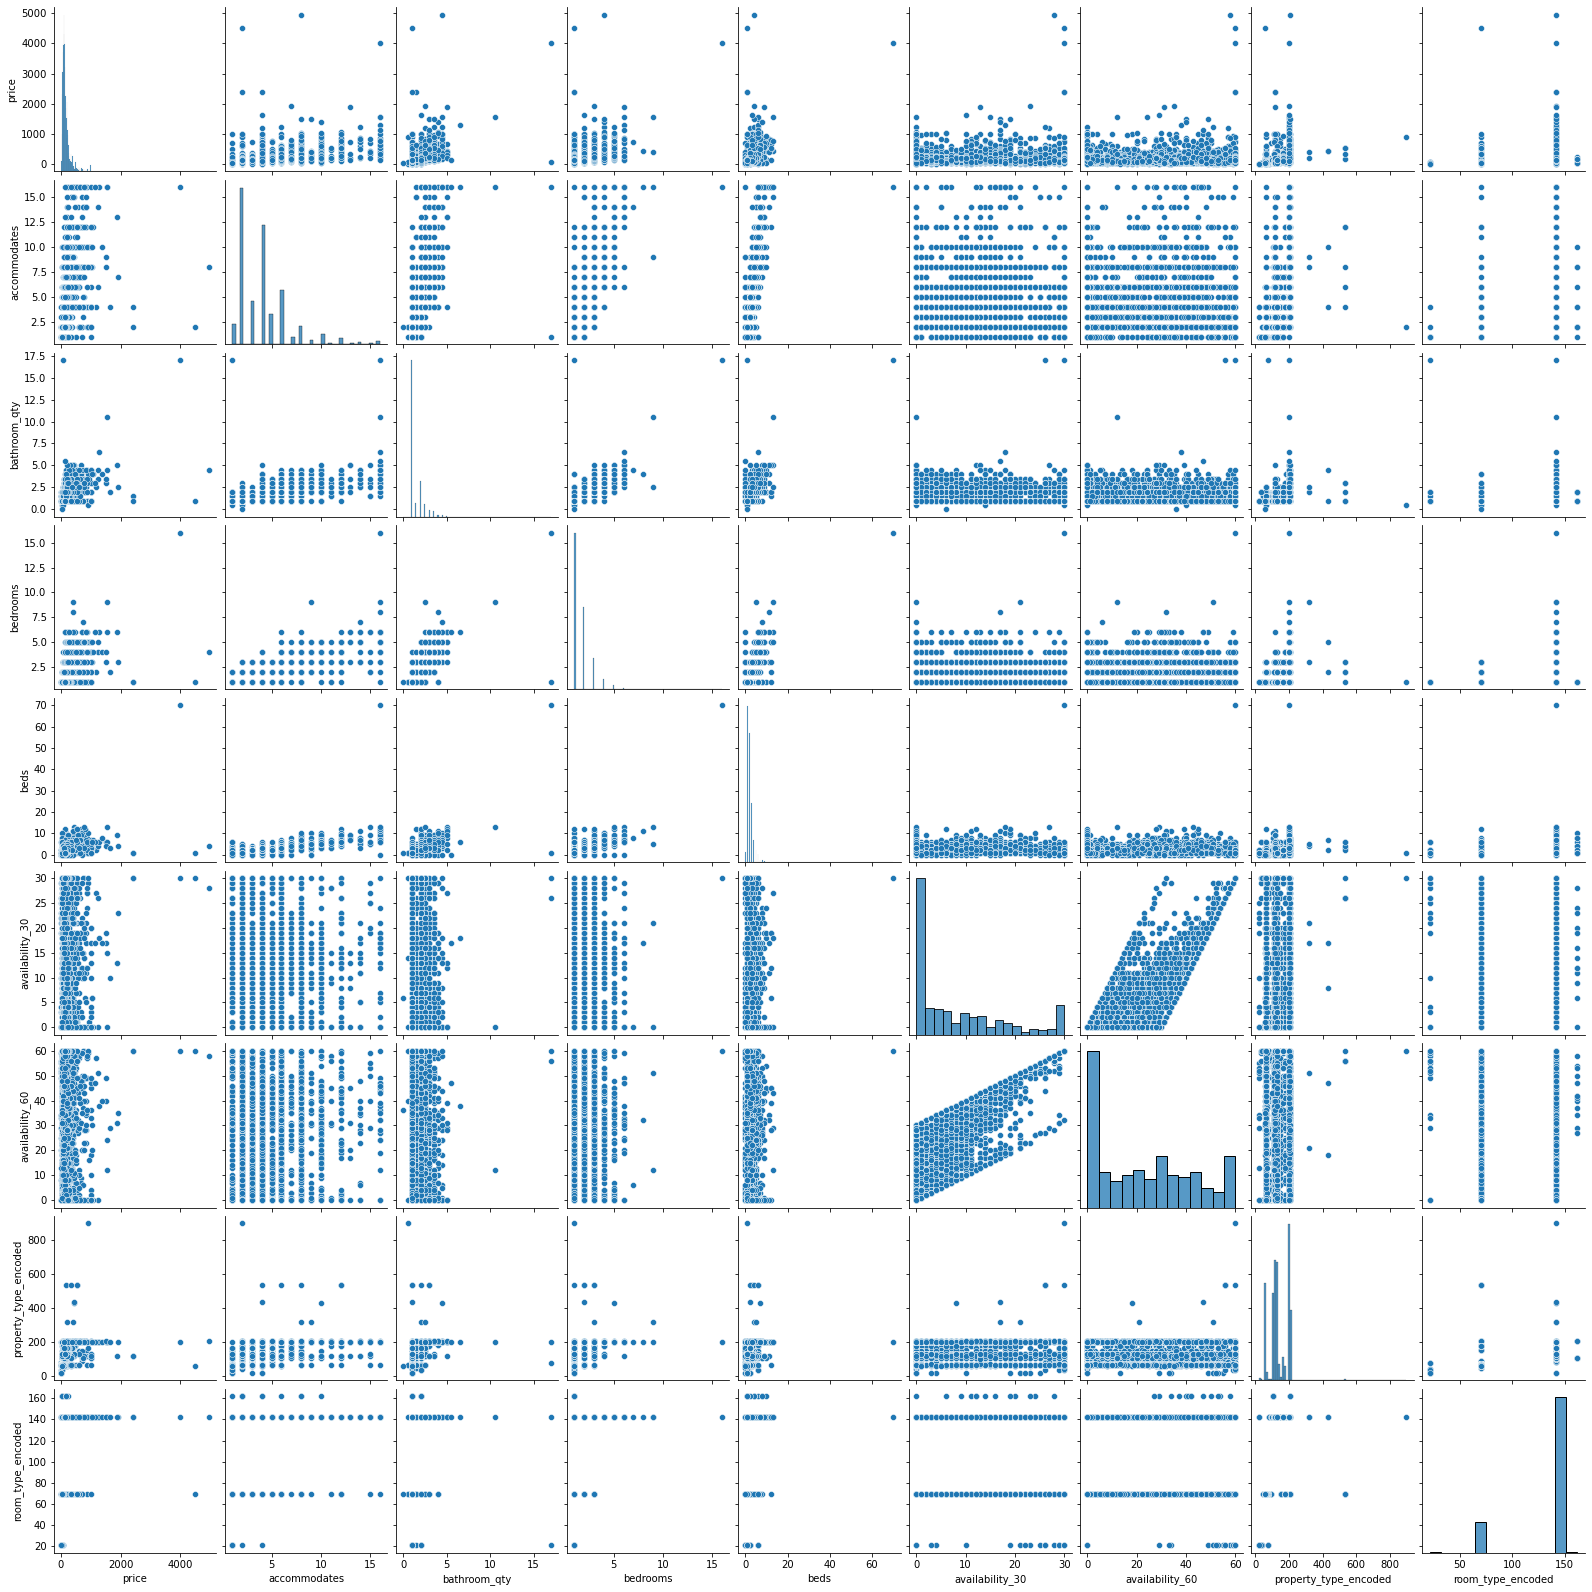

In [22]:
positive_corr_cols = list(corr_df.loc[corr_df['price'] > .1].index)
sns.pairplot(model_df[positive_corr_cols])

### Negative Values

In [23]:
corr_df.loc[corr_df['price'] < -.1]

,price
shared_bathroom,-0.136992


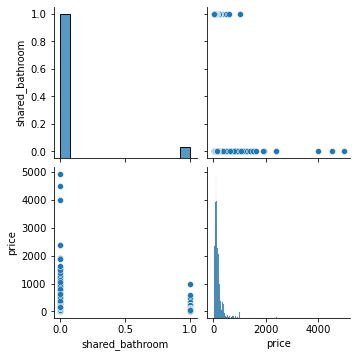

In [24]:
positive_corr_cols = list(corr_df.loc[corr_df['price'] < -.1].index)
positive_corr_cols.append('price')
sns.pairplot(model_df[positive_corr_cols])

# 4) Modeling
    
    Initially I performed a multiple linear reggression and tried to optimize the parameters by selecting the minimal number of features for the model. However, further research and feedback lead to trying multiple models and cross validating them.

In [25]:
import re
model_df = model_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X = model_df.copy().drop('price', axis = 1)
y = model_df['price'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [26]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Machine Learning

In [27]:
lr = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=50000, tol=.001)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

In [28]:
for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    mrse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
    y_pred = model.predict(X_test_scaled)
    mrse_test = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    best_alpha = ''
    if name != 'LinearRegression':
        best_alpha = ' best alpha: ' + str(model.alpha_)
    best_l1 = ''
    if name == 'ElasticNet':
        best_l1 = ' best l1: '+ str(model.l1_ratio_)
    print(name + ' mrse_train: ' + str(mrse_train) + ', mrse_test: ' + str(mrse_test) + best_alpha + best_l1)
    print('score:', model.score(X_test_scaled, y_test))

LinearRegression mrse_train: 172.6914655020935, mrse_test: 140.04554409995717
score: 0.32753499885961834
Ridge mrse_train: 174.53489265378337, mrse_test: 140.44870880144086 best alpha: 1000.0
score: 0.3236576260172952
Lasso mrse_train: 172.69619988165957, mrse_test: 140.05615263281715 best alpha: 0.01
score: 0.32743311575716105
ElasticNet mrse_train: 174.5331169041869, mrse_test: 140.6805275507444 best alpha: 1.0 best l1: 0.7
score: 0.3214230987066241


C:\Users\Trey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27037.197682768106, tolerance: 12200.220050173457
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Trey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11598.971361666918, tolerance: 10448.448200693841
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Trey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15842.688556447625, tolerance: 12069.037067172594
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Trey\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: 

# LGBM Regressor

#### Untuned

In [29]:
untuned_gbm = lgb.LGBMRegressor()
untuned_gbm.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)])

[1]	valid_0's rmse: 164.185	valid_0's l2: 26956.6
[2]	valid_0's rmse: 159.112	valid_0's l2: 25316.7
[3]	valid_0's rmse: 155.238	valid_0's l2: 24098.9
[4]	valid_0's rmse: 152.021	valid_0's l2: 23110.4
[5]	valid_0's rmse: 149.038	valid_0's l2: 22212.5
[6]	valid_0's rmse: 146.703	valid_0's l2: 21521.9
[7]	valid_0's rmse: 144.786	valid_0's l2: 20963
[8]	valid_0's rmse: 143.211	valid_0's l2: 20509.4
[9]	valid_0's rmse: 141.713	valid_0's l2: 20082.6
[10]	valid_0's rmse: 140.685	valid_0's l2: 19792.3
[11]	valid_0's rmse: 139.35	valid_0's l2: 19418.3
[12]	valid_0's rmse: 138.864	valid_0's l2: 19283.3
[13]	valid_0's rmse: 138.305	valid_0's l2: 19128.1
[14]	valid_0's rmse: 137.691	valid_0's l2: 18958.8
[15]	valid_0's rmse: 137.168	valid_0's l2: 18815
[16]	valid_0's rmse: 136.749	valid_0's l2: 18700.2
[17]	valid_0's rmse: 136.592	valid_0's l2: 18657.3
[18]	valid_0's rmse: 136.182	valid_0's l2: 18545.4
[19]	valid_0's rmse: 135.989	valid_0's l2: 18492.9
[20]	valid_0's rmse: 135.99	valid_0's l2: 184

LGBMRegressor()

In [30]:
untuned_gbm.score(X_test, y_test)

0.3321837555055397

#### Tunning

In [31]:
# https://www.vantage-ai.com/en/blog/bayesian-optimization-for-quicker-hyperparameter-tuning <--- guide I followed

In [32]:
hyper_params_random = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    "num_leaves": list(range(5, 50)),
    "max_depth": list(range(2, 11)),
    'learning_rate': list(np.logspace(np.log(0.01), np.log(1), num = 50, base=3)),
    'objective': ['regression'],
    'metric': ['rmse'],
    'feature_fraction': list(np.logspace(np.log(0.01), np.log(1), num = 50, base=3)),
    'max_bin':list(range(200, 600))
}

In [33]:
def search(model, parameters, X_train, y_train, X_test, y_test, n_iter=None):
    
    start = time.time() 
    

    grid_obj = RandomizedSearchCV(estimator=model,
                        param_distributions=parameters,
                        cv=5,
                        n_iter=n_iter,
                        refit=True,
                        return_train_score=False,
                        scoring = 'neg_root_mean_squared_error',
                        random_state=1)
    grid_obj.fit(X_train, y_train,)


    estimator = grid_obj.best_estimator_
    cvs = cross_val_score(estimator, X_train, y_train, cv=5)
    results = pd.DataFrame(grid_obj.cv_results_)
    
    print("##### Results")
    print("Score best parameters: ", grid_obj.best_score_)
    print("Best parameters: ", grid_obj.best_params_)
    print("Cross-validation Score: ", cvs.mean())
    print("Test Score: ", estimator.score(X_test, y_test))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ",results.shape[0])
    
    return results, grid_obj

In [34]:
results_xgb, estimator_xgb = search(lgb.LGBMRegressor(), hyper_params_random, X_train_scaled, y_train, X_test_scaled, y_test, 100)

[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.03313114987814973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.03313114987814973
[LightGBM] [Warning] feature_fraction is set=0.006350024818026649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.006350024818026649
[LightGBM] [Warning] feature_fraction is set=0.006350024818026

[LightGBM] [Warning] feature_fraction is set=0.024305947495475686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.024305947495475686
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.014504606991435907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.014504606991435907
[LightGBM] [Warning] feature_fraction is set=0.05551

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.007040714604964036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.007040714604964036
[LightGBM] [Warning] feature_fraction is set=0.016082267583263126, colsample_bytree=1.

[LightGBM] [Warning] feature_fraction is set=0.437793648719745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437793648719745
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.00959711489830881, colsample_bytree=1.0 w

[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.901900612978913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.901900612978913
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.036734812463116
[LightGBM] [Warning] feature_fraction is set=0.036734812463116, colsample_bytree=1.0 wil

[LightGBM] [Warning] feature_fraction is set=0.021921548945202783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.021921548945202783
[LightGBM] [Warning] feature_fraction is set=0.021921548945202783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.021921548945202783
[LightGBM] [Warning] feature_fraction is set=0.021921548945202783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.021921548945202783
[LightGBM] [Warning] feature_fraction is set=0.021921548945202783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.021921548945202783
[LightGBM] [Warning] feature_fraction is set=0.021921548945202783, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.021921548945202783
[LightGBM] [Warning] feature_fraction is set=0.3948463601386129, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3948463601386129
[LightGBM] [Warning] feature_fraction is set=0.394846360

[LightGBM] [Warning] feature_fraction is set=0.01064098943963485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01064098943963485
[LightGBM] [Warning] feature_fraction is set=0.01064098943963485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01064098943963485
[LightGBM] [Warning] feature_fraction is set=0.01064098943963485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.01064098943963485
[LightGBM] [Warning] feature_fraction is set=0.06155798799042481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06155798799042481
[LightGBM] [Warning] feature_fraction is set=0.06155798799042481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06155798799042481
[LightGBM] [Warning] feature_fraction is set=0.06155798799042481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06155798799042481
[LightGBM] [Warning] feature_fraction is set=0.06155798799042481

[LightGBM] [Warning] feature_fraction is set=0.07567754802984532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07567754802984532
[LightGBM] [Warning] feature_fraction is set=0.07567754802984532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07567754802984532
[LightGBM] [Warning] feature_fraction is set=0.07567754802984532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.07567754802984532
[LightGBM] [Warning] feature_fraction is set=0.013081713936594264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.013081713936594264
[LightGBM] [Warning] feature_fraction is set=0.013081713936594264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.013081713936594264
[LightGBM] [Warning] feature_fraction is set=0.013081713936594264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.013081713936594264
[LightGBM] [Warning] feature_fraction is set=0.01308171393

[LightGBM] [Warning] feature_fraction is set=0.17286122868879383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17286122868879383
[LightGBM] [Warning] feature_fraction is set=0.17286122868879383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17286122868879383
[LightGBM] [Warning] feature_fraction is set=0.17286122868879383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.17286122868879383
[LightGBM] [Warning] feature_fraction is set=0.06825362695685862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06825362695685862
[LightGBM] [Warning] feature_fraction is set=0.06825362695685862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06825362695685862
[LightGBM] [Warning] feature_fraction is set=0.06825362695685862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.06825362695685862
[LightGBM] [Warning] feature_fraction is set=0.06825362695685862

[LightGBM] [Warning] feature_fraction is set=0.011798405818229156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011798405818229156
[LightGBM] [Warning] feature_fraction is set=0.011798405818229156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011798405818229156
[LightGBM] [Warning] feature_fraction is set=0.011798405818229156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.011798405818229156
[LightGBM] [Warning] feature_fraction is set=0.26125395108372745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26125395108372745
[LightGBM] [Warning] feature_fraction is set=0.26125395108372745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26125395108372745
[LightGBM] [Warning] feature_fraction is set=0.26125395108372745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26125395108372745
[LightGBM] [Warning] feature_fraction is set=0.26125395108

### Best Model

In [35]:
feature_cols = model_df.copy().drop('price', axis = 1).columns
feature_values = estimator_xgb.best_estimator_.feature_importances_
feature_data = dict(zip(feature_cols, feature_values))
feat_df = pd.DataFrame(data = feature_data, index=[0])

In [36]:
def plot_features(feature_df, score=50):
    df = feature_df.copy()
    df_cols = list(df.columns)
    for df_col in df_cols:
        if int(df[df_col][0]) < score:
            df.drop(columns=df_col, inplace=True)
    
    plt.figure(figsize = (15,8))
    fig = sns.barplot(x=df.columns, y=df.values.tolist()[0])
    plt.xticks(rotation=85);
    
    return df.columns

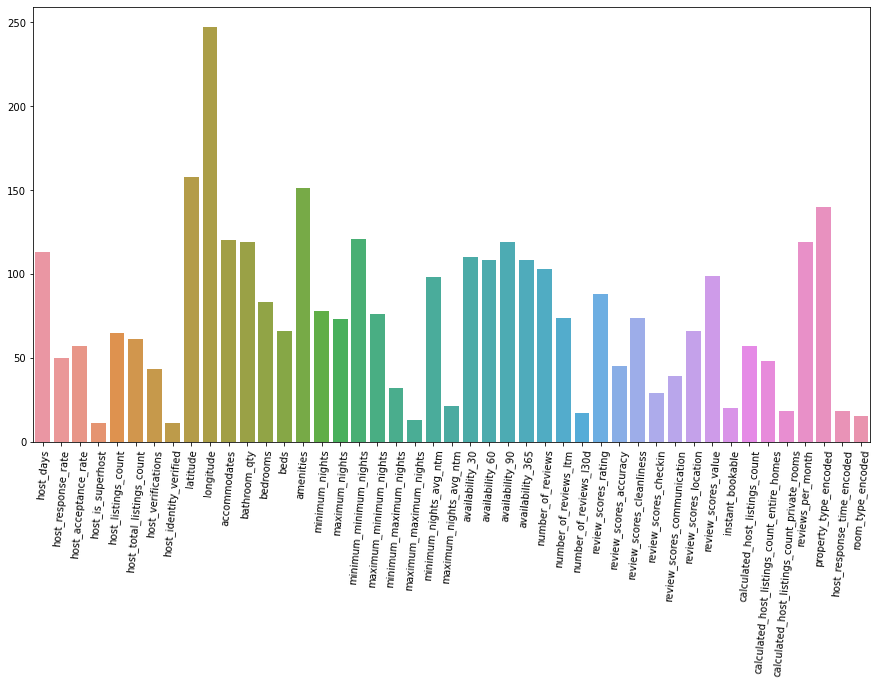

In [37]:
important_features = plot_features(feat_df, 10)

### Predictions

In [41]:
'''Given a Listing ID this function will predict the value with our new model'''
def predict_price(listing_id):
    
    prediction_df = master_df.replace(np.log(0), 0)
    prediction_df = prediction_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    prediction_df = prediction_df.loc[prediction_df['id'] == listing_id]

    X = prediction_df.drop(columns = ['price', 'id'])

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scaled = scaler.transform(X)
    
    print('Listing URL', listingsGZ_df['listing_url'].loc[listingsGZ_df['id'] == listing_id].reset_index(drop=True)[0])
    print('Actual Price:', master_df['price'].loc[master_df['id'] == listing_id].reset_index(drop=True)[0])
    print('Predicted Price:', round(estimator_xgb.predict(X_scaled)[0]) )

In [39]:
### These are listings with no reviews and have a very high price!
master_df[['price', 'id']].loc[(master_df['number_of_reviews'] == 0) & (master_df['price'] > 1000)]

,price,id
2470,4950.0,45518735
2617,3999.0,46276109
2787,2400.0,47818271
2860,2400.0,48203026
3707,1045.0,51969004


In [42]:
predict_price(51969004)

Listing URL https://www.airbnb.com/rooms/51969004
Actual Price: 1045.0
Predicted Price: 637


<ipython-input-41-36a0f986aaad>:4: RuntimeWarning: divide by zero encountered in log
  prediction_df = master_df.replace(np.log(0), 0)


In [43]:
y_pred = estimator_xgb.predict(X_test_scaled)

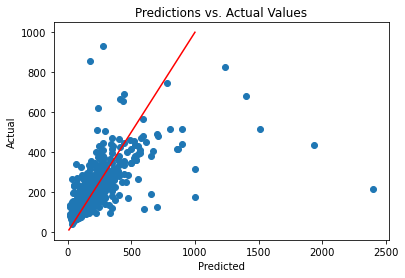

In [44]:
plt.scatter(y_test, y_pred)
plt.plot([x for x in range(9,1000)],[x for x in range(9,1000)], color='red')
plt.title("Predictions vs. Actual Values")
plt.xlabel("Predicted")
plt.ylabel("Actual");

# Conclusion

#### Model and Use Case
    The Model I built uses LGBMRegressor() and the inputs are a listings row of data. Since this model is intended to determine pricing for AirBnB listings in Denver, all listings will exist within the database. So, once somebody lists their Airbnb they can input their listing id into the model and recieve a pricing reccomendation. 
#### Future Iterations of the Model
    There are many softwares to use for listing a housing property (VRBO, Evolve, etc). So, creating a model that is informative for features that are well known (locations, number of rooms) could be used to provide pricing information for what somebody could make if they want to use AirBnB to list their property. Ex. Somebody currently has their listing on VRBO and would like to know what price point they would be at if they used AirBnB. Or an investor could use the tool to get an idea of how much money a property could generate if they were to buy it.